In [1]:
#Mount my drive- run the code, go to the link, accept.
from google.colab import drive
drive.mount('/content/gdrive')

#Change working directory to make it easier to access the files
import os
os.chdir("/content/gdrive/My Drive/Colab Notebooks/dinn")
os.getcwd() 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content/gdrive/My Drive/Colab Notebooks/dinn'

In [2]:
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

zika_data = genfromtxt('zika.csv', delimiter=',') #in the form of [t, Sh, Eh, Ih1, Ih2, Ah, Rh, Sv, Ev, Iv]

torch.manual_seed(1234)

In [3]:
%%time

PATH = 'zika' 

class DINN(nn.Module):
    def __init__(self, t, Sh_data, Eh_data, Ih1_data, Ih2_data, Ah_data, Rh_data, Sv_data, Ev_data, Iv_data):
        super(DINN, self).__init__()
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 
        self.Sh = torch.tensor(Sh_data)
        self.Eh = torch.tensor(Eh_data)
        self.Ih1 = torch.tensor(Ih1_data)
        self.Ih2 = torch.tensor(Ih2_data)
        self.Ah = torch.tensor(Ah_data)
        self.Rh = torch.tensor(Rh_data)
        self.Sv = torch.tensor(Sv_data)
        self.Ev = torch.tensor(Ev_data)
        self.Iv = torch.tensor(Iv_data)
        self.Nh = self.Sh + self.Eh + self.Ih1 + self.Ih2 + self.Ah + self.Rh
        self.Nv = 5 * self.Nh

        self.losses = [] #keep the losses
        self.save = 3 #which file to save to

        #learnable parameters
        self.a_tilda = torch.tensor(0.5) #torch.nn.Parameter(torch.rand(1, requires_grad=True))
        self.b_tilda = torch.tensor(0.4)
        self.c_tilda = torch.tensor(0.5)
        self.eta_tilda = torch.tensor(0.1)
        self.beta_tilda = torch.tensor(0.05)
        self.kappa_tilda = torch.tensor(0.6)
        self.tao_tilda = torch.tensor(0.3)
        self.theta_tilda = torch.tensor(18)
        self.m_tilda = torch.tensor(5)
        self.V_h_tilda = torch.tensor(1/5)
        self.V_v_tilda = torch.tensor(10)
        self.gamma_h1_tilda = torch.tensor(1/5)
        self.gamma_h2_tilda = torch.tensor(1/20)
        self.gamma_h_tilda = torch.tensor(1/7)
        self.mu_v_tilda = torch.tensor(1/14)

        #matrices (x9 for Sh, Eh, Ih1, Ih2, Ah, Rh, Sv, Ev, Iv) for the gradients
        self.m1 = torch.zeros((len(self.t), 9)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 9)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 9)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 9)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 9)); self.m5[:, 4] = 1
        self.m6 = torch.zeros((len(self.t), 9)); self.m6[:, 5] = 1
        self.m7 = torch.zeros((len(self.t), 9)); self.m7[:, 6] = 1
        self.m8 = torch.zeros((len(self.t), 9)); self.m8[:, 7] = 1
        self.m9 = torch.zeros((len(self.t), 9)); self.m9[:, 8] = 1

        #values for norm
        self.Sh_max = max(self.Sh)
        self.Eh_max = max(self.Eh)
        self.Ih1_max = max(self.Ih1)
        self.Ih2_max = max(self.Ih2)
        self.Ah_max = max(self.Ah)
        self.Rh_max = max(self.Rh)
        self.Sv_max = max(self.Sv)
        self.Ev_max = max(self.Ev)
        self.Iv_max = max(self.Iv)
        self.Sh_min = min(self.Sh)
        self.Eh_min = min(self.Eh)
        self.Ih1_min = min(self.Ih1)
        self.Ih2_min = min(self.Ih2)
        self.Ah_min = min(self.Ah)
        self.Rh_min = min(self.Rh)
        self.Sv_min = min(self.Sv)
        self.Ev_min = min(self.Ev)
        self.Iv_min = min(self.Iv)

        #normalize 
        self.Sh_hat = (self.Sh - self.Sh_min)/(self.Sh_max - self.Sh_min)
        self.Eh_hat = (self.Eh - self.Eh_min)/(self.Eh_max - self.Eh_min)
        self.Ih1_hat = (self.Ih1 - self.Ih1_min)/(self.Ih1_max - self.Ih1_min)
        self.Ih2_hat = (self.Ih2 - self.Ih2_min)/(self.Ih2_max - self.Ih2_min)
        self.Ah_hat = (self.Ah - self.Ah_min)/(self.Ah_max - self.Ah_min)
        self.Rh_hat = (self.Rh - self.Rh_min)/(self.Rh_max - self.Rh_min)
        self.Sv_hat = (self.Sv - self.Sv_min)/(self.Sv_max - self.Sv_min)
        self.Ev_hat = (self.Ev - self.Ev_min)/(self.Ev_max - self.Ev_min)
        self.Iv_hat = (self.Iv - self.Iv_min)/(self.Iv_max - self.Iv_min)

        #NN
        self.net_zika = self.Net_zika()
        self.params = list(self.net_zika.parameters())
        self.params.extend(list([self.a_tilda, self.b_tilda, self.c_tilda, self.eta_tilda, self.beta_tilda, self.kappa_tilda, self.tao_tilda, self.theta_tilda, self.m_tilda, self.V_h_tilda, self.V_v_tilda, self.gamma_h1_tilda, self.gamma_h2_tilda, self.gamma_h_tilda, self.mu_v_tilda]))

        
    #force parameters to be in a range
    @property 
    def a(self):
        return self.a_tilda #torch.taself.nh(self.a_tilda)

    @property 
    def b(self):
        return self.b_tilda #torch.taself.nh(self.b_tilda)

    @property 
    def c(self):
        return self.c_tilda #torch.taself.nh(self.c_tilda)

    @property 
    def eta(self):
        return self.eta_tilda #torch.taself.nh(self.e_tilda)

    @property 
    def beta(self):
        return self.beta_tilda #torch.taself.nh(self.b_tilda)

    @property 
    def kappa(self):
        return self.kappa_tilda #torch.taself.nh(self.k_tilda)

    @property 
    def tao(self):
        return self.tao_tilda #torch.taself.nh(self.t_tilda)

    @property 
    def theta(self):
        return self.theta_tilda #torch.taself.nh(self.t_tilda)

    @property 
    def m(self):
        return self.m_tilda #torch.taself.nh(self.m_tilda)

    @property 
    def V_h(self):
        return self.V_h_tilda #torch.taself.nh(self.V_tilda)

    @property 
    def V_v(self):
        return self.V_v_tilda #torch.taself.nh(self.V_tilda)

    @property 
    def gamma_h1(self):
        return self.gamma_h1_tilda #torch.taself.nh(self.g_tilda)

    @property 
    def gamma_h2(self):
        return self.gamma_h2_tilda #torch.taself.nh(self.g_tilda)

    @property 
    def gamma_h(self):
        return self.gamma_h_tilda #torch.taself.nh(self.g_tilda)

    @property 
    def mu_v(self):
        return self.mu_v_tilda #torch.taself.nh(self.m_tilda)


    #nets
    class Net_zika(nn.Module): # input = [t]
        def __init__(self):
            super(DINN.Net_zika, self).__init__()
            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 9) #outputs Sh, Eh, Ih1, Ih2, Ah, Rh, Sv, Ev, Iv

        def forward(self, t):
            zika=F.relu(self.fc1(t))
            zika=F.relu(self.fc2(zika))
            zika=F.relu(self.fc3(zika))
            zika=F.relu(self.fc4(zika))
            zika=F.relu(self.fc5(zika))
            zika=F.relu(self.fc6(zika))
            zika=F.relu(self.fc7(zika))
            zika=F.relu(self.fc8(zika))
            zika=self.out(zika)
            return zika    

    def net_f(self, t_batch):       

        zika_hat = self.net_zika(t_batch)

        Sh_hat, Eh_hat, Ih1_hat, Ih2_hat, Ah_hat, Rh_hat, Sv_hat, Ev_hat, Iv_hat = zika_hat[:,0], zika_hat[:,1], zika_hat[:,2], zika_hat[:,3], zika_hat[:,4], zika_hat[:,5], zika_hat[:,6], zika_hat[:,7], zika_hat[:,8]

        #Sh_hat
        zika_hat.backward(self.m1, retain_graph=True)
        Sh_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Eh_hat
        zika_hat.backward(self.m2, retain_graph=True)
        Eh_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Ih1_hat
        zika_hat.backward(self.m3, retain_graph=True)
        Ih1_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Ih2_hat
        zika_hat.backward(self.m4, retain_graph=True)
        Ih2_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Ah_hat
        zika_hat.backward(self.m5, retain_graph=True)
        Ah_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Rh_hat
        zika_hat.backward(self.m6, retain_graph=True)
        Rh_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Sv_hat
        zika_hat.backward(self.m7, retain_graph=True)
        Sv_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Ev_hat
        zika_hat.backward(self.m8, retain_graph=True)
        Ev_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Iv_hat
        zika_hat.backward(self.m9, retain_graph=True)
        Iv_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #unnormalize
        Sh = self.Sh_min + (self.Sh_max - self.Sh_min) * Sh_hat
        Eh = self.Eh_min + (self.Eh_max - self.Eh_min) * Eh_hat
        Ih1 = self.Ih1_min + (self.Ih1_max - self.Ih1_min) * Ih1_hat
        Ih2 =  self.Ih2_min + (self.Ih2_max - self.Ih2_min) * Ih2_hat
        Ah = self.Ah_min + (self.Ah_max - self.Ah_min) * Ah_hat
        Rh = self.Rh_min + (self.Rh_max - self.Rh_min) * Rh_hat
        Sv = self.Sv_min + (self.Sv_max - self.Sv_min) * Sv_hat
        Ev = self.Ev_min + (self.Ev_max - self.Ev_min) * Ev_hat
        Iv = self.Iv_min + (self.Iv_max - self.Iv_min) * Iv_hat

        #equations
        f1_hat = Sh_hat_t - (-self.a * self.b * (Iv/self.Nh) * Sh - self.beta * ((self.kappa * Eh + self.Ih1 + self.tao * Ih2) / self.Nh ) * Sh) / (self.Sh_max - self.Sh_min) 
        f2_hat = Eh_hat_t - (self.theta * (-self.a * self.b * (Iv/self.Nh) * Sh - self.beta * ((self.kappa * Eh + Ih1 + self.tao * Ih2) / self.Nh ) * Sh) - self.V_h * Eh) / (self.Eh_max - self.Eh_min) 
        f3_hat = Ih1_hat_t - (self.V_h * Eh - self.gamma_h1 * Ih1) / (self.Ih1_max - self.Ih1_min) 
        f4_hat = Ih2_hat_t - (self.gamma_h1 * Ih1 - self.gamma_h2 * Ih2) / (self.Ih2_max - self.Ih2_min) 
        f5_hat = Ah_hat_t - ((1 - self.theta) * (self.a * self.b * (Iv/self.Nh) * Sh - self.beta * ((self.kappa * Eh + Ih1 + self.tao * Ih2) / self.Nh ) * Sh) - self.gamma_h * Ah) / (self.Ah_max - self.Ah_min) 
        f6_hat = Rh_hat_t - (self.gamma_h2 * Ih2 + self.gamma_h * Ah) / (self.Rh_max - self.Rh_min) 
        f7_hat = Sv_hat_t - (self.mu_v * self.Nv - self.a * self.c * ((self.eta * Eh + Ih1)/self.Nh) * Sv - self.mu_v * Sv) / (self.Sv_max - self.Sv_min) 
        f8_hat = Ev_hat_t - (self.a * self.c * ((self.eta * Eh + Ih1)/self.Nh) - (self.V_v + self.mu_v) * Ev) / (self.Ev_max - self.Ev_min) 
        f9_hat = Iv_hat_t - (self.V_v * Ev - self.mu_v * Iv) / (self.Iv_max - self.Iv_min) 

        return f1_hat, f2_hat, f3_hat, f4_hat, f5_hat, f6_hat, f7_hat, f8_hat, f9_hat, Sh_hat, Eh_hat, Ih1_hat, Ih2_hat, Ah_hat, Rh_hat, Sv_hat, Ev_hat, Iv_hat
    
    def load(self):
      # Load checkpoint
      try:
        checkpoint = torch.load(PATH + str(self.save)+'.pt') 
        print('\nloading pre-trained model...')
        self.load_state_dict(checkpoint['model'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        self.losses = checkpoint['losses']
        print('loaded previous loss: ', loss)
      except RuntimeError :
          print('changed the architecture, ignore')
          pass
      except FileNotFoundError:
          pass

    def train(self, n_epochs):
      #try loading
      self.load()

      #train
      print('\nstarting training...\n')
      
      for epoch in range(n_epochs):
        #lists to hold the output (maintain only the final epoch)
        Sh_pred_list = []
        Eh_pred_list = []
        Ih1_pred_list = []
        Ih2_pred_list = []
        Ah_pred_list = []
        Rh_pred_list = []
        Sv_pred_list = []
        Ev_pred_list = []
        Iv_pred_list = []

        f1_hat, f2_hat, f3_hat, f4_hat, f5_hat, f6_hat, f7_hat, f8_hat, f9_hat, Sh_hat_pred, Eh_hat_pred, Ih1_hat_pred, Ih2_hat_pred, Ah_hat_pred, Rh_hat_pred, Sv_hat_pred, Ev_hat_pred, Iv_hat_pred = self.net_f(self.t_batch)
        self.optimizer.zero_grad()

        Sh_pred_list.append(self.Sh_min + (self.Sh_max - self.Sh_min) * Sh_hat_pred)
        Eh_pred_list.append(self.Eh_min + (self.Eh_max - self.Eh_min) * Eh_hat_pred)
        Ih1_pred_list.append(self.Ih1_min + (self.Ih1_max - self.Ih1_min) * Ih1_hat_pred)
        Ih2_pred_list.append(self.Ih2_min + (self.Ih2_max - self.Ih2_min) * Ih2_hat_pred)
        Ah_pred_list.append(self.Ah_min + (self.Ah_max - self.Ah_min) * Ah_hat_pred)
        Rh_pred_list.append(self.Rh_min + (self.Rh_max - self.Rh_min) * Rh_hat_pred)
        Sv_pred_list.append(self.Sv_min + (self.Sv_max - self.Sv_min) * Sv_hat_pred)
        Ev_pred_list.append(self.Ev_min + (self.Ev_max - self.Ev_min) * Ev_hat_pred)
        Iv_pred_list.append(self.Iv_min + (self.Iv_max - self.Iv_min) * Iv_hat_pred)

        loss = (
              torch.mean(torch.square(self.Sh_hat - Sh_hat_pred)) + torch.mean(torch.square(self.Eh_hat - Eh_hat_pred)) + 
              torch.mean(torch.square(self.Ih1_hat - Ih1_hat_pred)) + torch.mean(torch.square(self.Ih2_hat - Ih2_hat_pred)) + 
              torch.mean(torch.square(self.Ah_hat - Ah_hat_pred)) + torch.mean(torch.square(self.Rh_hat - Rh_hat_pred)) + 
              torch.mean(torch.square(self.Sv_hat - Sv_hat_pred)) + torch.mean(torch.square(self.Ev_hat - Ev_hat_pred)) + 
              torch.mean(torch.square(self.Iv_hat - Iv_hat_pred)) +
              torch.mean(torch.square(f1_hat)) + torch.mean(torch.square(f2_hat)) +
              torch.mean(torch.square(f3_hat)) + torch.mean(torch.square(f4_hat)) +
              torch.mean(torch.square(f5_hat)) + torch.mean(torch.square(f6_hat)) +
              torch.mean(torch.square(f7_hat)) + torch.mean(torch.square(f8_hat)) +
              torch.mean(torch.square(f9_hat))
               )

        loss.backward()

        self.optimizer.step()
        #self.scheduler.step() 
        self.scheduler.step(loss) 

        self.losses.append(loss.item())

        if epoch % 1000 == 0:          
          print('\nEpoch ', epoch)

        #loss + model parameters update
        if epoch % 4000 == 0:
          #checkpoint save every 1000 epochs if the loss is lower
          print('\nSaving model... Loss is: ', loss)
          torch.save({
              'epoch': epoch,
              'model': self.state_dict(),
              'optimizer_state_dict': self.optimizer.state_dict(),
              'scheduler': self.scheduler.state_dict(),
              'loss': loss,
              'losses': self.losses,
              }, PATH + str(self.save)+'.pt')
          if self.save % 2 > 0: #its on 3
            self.save = 2 #change to 2
          else: #its on 2
            self.save = 3 #change to 3

          print('epoch: ', epoch)
          # print('alpha1: (goal 1)', self.alpha1)
          # print('\nalpha2: (goal 0)', self.alpha2)
          # print('\nbeta: (goal 0.0075): ', self.beta)
          # print('\nmu (goal 5): ', self.mu)
          # print('\nu: (goal 0.515151515): ', self.u)
          # print('\ntao (goal 0.58): ', self.tao)
          print('#################################')
        
      #plot
      plt.plot(self.losses, color = 'teal')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      return Sh_pred_list, Eh_pred_list, Ih1_pred_list, Ih2_pred_list, Ah_pred_list, Rh_pred_list, Sv_pred_list, Ev_pred_list, Iv_pred_list

CPU times: user 53 µs, sys: 9 µs, total: 62 µs
Wall time: 65.6 µs



loading pre-trained model...
loaded previous loss:  tensor(0.1523, dtype=torch.float64, requires_grad=True)

starting training...


Epoch  0

Saving model... Loss is:  tensor(0.1523, dtype=torch.float64, grad_fn=<AddBackward0>)
epoch:  0
#################################
CPU times: user 214 ms, sys: 31.4 ms, total: 245 ms
Wall time: 263 ms


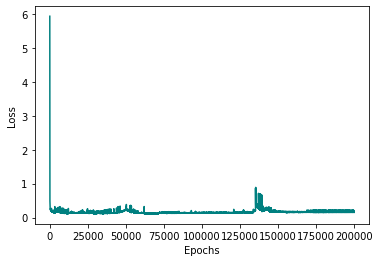

In [4]:
%%time

#this worked best
dinn = DINN(zika_data[0], zika_data[1], zika_data[2], zika_data[3], zika_data[4], zika_data[5], zika_data[6], zika_data[7], zika_data[8], zika_data[9]) #t, S_data, I_data

learning_rate = 1e-3
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(dinn.optimizer, factor=0.85, patience = 5000, verbose=True)
#scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-6, max_lr=1e-3, step_size_up=100, mode="triangular2", cycle_momentum=False)

dinn.scheduler = scheduler

try: 
  Sh_pred_list, Eh_pred_list, Ih1_pred_list, Ih2_pred_list, Ah_pred_list, Rh_pred_list, Sv_pred_list, Ev_pred_list, Iv_pred_list = dinn.train(1) #train
except EOFError:
  if dinn.save == 2:
    dinn.save = 3
    Sh_pred_list, Eh_pred_list, Ih1_pred_list, Ih2_pred_list, Ah_pred_list, Rh_pred_list, Sv_pred_list, Ev_pred_list, Iv_pred_list = dinn.train(1) #train
  elif dinn.save == 3:
    dinn.save = 2
    Sh_pred_list, Eh_pred_list, Ih1_pred_list, Ih2_pred_list, Ah_pred_list, Rh_pred_list, Sv_pred_list, Ev_pred_list, Iv_pred_list = dinn.train(1) #train

Text(0, 0.5, 'Loss')

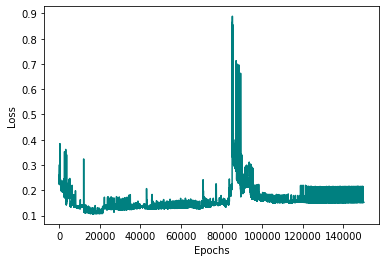

In [5]:
plt.plot(dinn.losses[50000:], color = 'teal')
plt.xlabel('Epochs')
plt.ylabel('Loss')

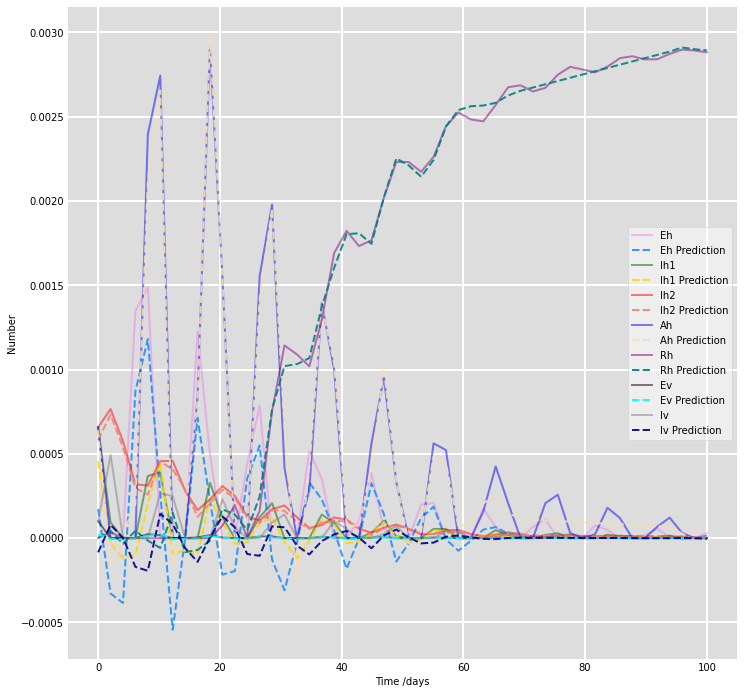

In [6]:
fig = plt.figure(facecolor='w', figsize=(12,12))
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

# ax.plot(zika_data[0], zika_data[1], 'pink', alpha=0.5, lw=2, label='Sh')
# ax.plot(zika_data[0], Sh_pred_list[0].detach().numpy(), 'navy', alpha=0.9, lw=2, label='Sh Prediction', linestyle='dashed')

ax.plot(zika_data[0], zika_data[2], 'violet', alpha=0.5, lw=2, label='Eh')
ax.plot(zika_data[0], Eh_pred_list[0].detach().numpy(), 'dodgerblue', alpha=0.9, lw=2, label='Eh Prediction', linestyle='dashed')

ax.plot(zika_data[0], zika_data[3], 'darkgreen', alpha=0.5, lw=2, label='Ih1')
ax.plot(zika_data[0], Ih1_pred_list[0].detach().numpy(), 'gold', alpha=0.9, lw=2, label='Ih1 Prediction', linestyle='dashed')

ax.plot(zika_data[0], zika_data[4], 'red', alpha=0.5, lw=2, label='Ih2')
ax.plot(zika_data[0], Ih2_pred_list[0].detach().numpy(), 'salmon', alpha=0.9, lw=2, label='Ih2 Prediction', linestyle='dashed')

ax.plot(zika_data[0], zika_data[5], 'blue', alpha=0.5, lw=2, label='Ah')
ax.plot(zika_data[0], Ah_pred_list[0].detach().numpy(), 'wheat', alpha=0.9, lw=2, label='Ah Prediction', linestyle='dashed')

ax.plot(zika_data[0], zika_data[6], 'purple', alpha=0.5, lw=2, label='Rh')
ax.plot(zika_data[0], Rh_pred_list[0].detach().numpy(), 'teal', alpha=0.9, lw=2, label='Rh Prediction', linestyle='dashed')

# ax.plot(zika_data[0], zika_data[7], 'yellow', alpha=0.5, lw=2, label='Sv')
# ax.plot(zika_data[0], Sv_pred_list[0].detach().numpy(), 'slategrey', alpha=0.9, lw=2, label='Sv Prediction', linestyle='dashed')

ax.plot(zika_data[0], zika_data[8], 'black', alpha=0.5, lw=2, label='Ev')
ax.plot(zika_data[0], Ev_pred_list[0].detach().numpy(), 'aqua', alpha=0.9, lw=2, label='Ev Prediction', linestyle='dashed')

ax.plot(zika_data[0], zika_data[9], 'grey', alpha=0.5, lw=2, label='Iv')
ax.plot(zika_data[0], Iv_pred_list[0].detach().numpy(), 'darkblue', alpha=0.9, lw=2, label='Iv Prediction', linestyle='dashed')


ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
#ax.set_ylim([-1,50])
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [7]:
-print('alpha1: (goal 1)', round(dinn.alpha1.item(),2))
print('\nalpha2: (goal 0)', round(dinn.alpha2.item(),2))
print('\nbeta: (goal 0.0075): ', round(dinn.beta.item(),4))
print('\nmu (goal 5): ', round(dinn.mu.item(),2))
print('\nu: (goal 0.515151515): ', round(dinn.u.item(),2))
print('\ntao (goal 0.58): ', round(dinn.tao.item(),2))


print('\nerror:')
print('alpha1: ', round((1-round(dinn.alpha1.item(),2))/1,2)*100,'%')
print('alpha2: ', round((0-round(dinn.alpha2.item(),2))/1e-20,2)*100,'%')
print('beta: ', round((0.0075-round(dinn.beta.item(),4))/0.0075,2)*100,'%')
print('mu: ', round((5-round(dinn.mu.item(),2))/5,2)*100,'%')
print('u: ', round((0.515151515-round(dinn.u.item(),2))/0.515151515,2)*100,'%')
print('tao: ', round((0.58-round(dinn.tao.item(),2))/0.58,2)*100,'%')

AttributeError: ignored

In [ ]:
#vaccination! 

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Initial number of infected individuals, I0
I0 = 1
# Everyone else, S0, is susceptible to infection initially.
S0 = 2000
# Contact rate, beta, and mean recovery rate, mu.
beta, mu = dinn.beta, dinn.mu
# A grid of time points (in days)
t = np.linspace(0, 3, 100) 
#parameters
u = dinn.u
tao = dinn.tao
alpha1 = dinn.alpha1
alpha2 = dinn.alpha2

# The SIR model differential equations.
def deriv(y, t, beta, mu, u, tao, alpha1, alpha2):
    S, I = y
    dSdt = -beta * S * I + u * (t > tao) * alpha1 * (-S)
    dIdt = beta * S * I - mu * I + u * (t > tao) * alpha2 * (-I)
    return dSdt, dIdt

#add u = 0.5, get the corresponding tao, generate the SI data
# learn u (self.u), the corresponding tao (self.tao)

# Initial conditions vector
y0 = S0, I0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(beta, mu, u, tao, alpha1, alpha2))
S, I = ret.T

# Plot the data on two separate curves for S(t), I(t)
fig = plt.figure(facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(tSI_vaccination_data[0], tSI_vaccination_data[1], 'navy', alpha=0.9, lw=2, label='Actual Susceptible')
ax.plot(t, S, 'violet', alpha=0.5, lw=2, label='Learnable Param Susceptible', linestyle='dashed')
ax.plot(tSI_vaccination_data[0], tSI_vaccination_data[2], 'dodgerblue', alpha=0.9, lw=2, label='Actual Infected')
ax.plot(t, I, 'darkgreen', alpha=0.5, lw=2, label='Learnable Param Infected', linestyle='dashed')
ax.set_xlabel('Time /days')
#ax.set_ylabel('Number (1000s)')
#ax.set_ylim(0,1.2)
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='w', lw=2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [ ]:
#calculate relative MSE loss
import math

S_total_loss = 0
S_den = 0
I_total_loss = 0
I_den = 0
for timestep in range(len(t)):
  S_value = tSI_vaccination_data[1][timestep] - S[timestep]
  S_total_loss += S_value**2
  S_den += (tSI_vaccination_data[1][timestep])**2
  I_value = tSI_vaccination_data[2][timestep] - I[timestep]
  I_total_loss += I_value**2
  I_den += (tSI_vaccination_data[2][timestep])**2

S_total_loss = math.sqrt(S_total_loss/S_den)

I_total_loss = math.sqrt(I_total_loss/I_den)
print('S_total_loss: ', S_total_loss)
print('I_total_loss: ', I_total_loss)